In [1]:
import numpy as np
from numpy import arange
from astropy.io import ascii
import astropy.units as u
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
from astropy.modeling import models
from scipy.optimize import curve_fit

In [25]:
RA = 10
DEC = 10
R = 0.1
V_lim = 18
Cat_len = -1

In [26]:
# My_Cat = Table()
# make astropy SkyCoord object
coord = SkyCoord(ra=RA * u.degree, dec=DEC * u.degree, frame='icrs')
# set search cone   
radius = Angle(R * u.deg)
# set columns
V = Vizier(columns=['RAJ2000', 'DEJ2000',
                    '+_Gmag', 'Gmag', 'BPmag', 'pmRA', 'pmDE',
                    'RPmag', "_r", 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag',
                    'gmag', 'imag', 'rmag', 'ymag', 'zmag', 'e_Gmag', 'e_BPmag','e_RPmag',
                    'e_Jmag','e_Hmag','e_Kmag',
                    'e_W1mag', 'e_W2mag', 'e_W3mag', 'e_W4mag',
                    'e_gmag', 'e_imag', 'e_rmag', 'e_ymag', 'e_zmag']) 
# set limit of rows, sort by distance default
V.ROW_LIMIT = Cat_len
catalog = ['I/355/gaiadr3', 'II/246/out', 'II/328/allwise', 'II/349/ps1']
# get data
Gaia_tab = V.query_region(coord, radius=radius, catalog=catalog)[0]
# Gaia_tab = V.query_region(coord, radius=radius, catalog=['I/355/gaiadr3'])
# print(Gaia_tab)
# print(Gaia_tab[0])



In [ ]:
Gaia_tab

In [5]:
Gaia_tab = np.load('gaia_cat.npy')

In [ ]:
fig1, ax1 = plt.subplots(dpi=150)
ax1.set_xlabel(r"alpha, deg")
ax1.set_ylabel(r"delta, deg")
ax1.grid()

# colors = np.array([np.max(My_Cat['G']), np.min(My_Cat['G'])])
scatter = ax1.scatter(Gaia_tab['RAJ2000'], Gaia_tab['DEJ2000'], c=Gaia_tab['Gmag'], cmap='viridis')
fig1.colorbar(scatter)
plt.savefig(f"result_scatter.png")

fig2, ax2 = plt.subplots(dpi=150)
ax2.set_xlabel(r"alpha, deg")
ax2.set_ylabel(r"delta, deg")
ax2.grid()
ax2.quiver(Gaia_tab['RAJ2000'].filled(0), Gaia_tab['DEJ2000'].filled(0), Gaia_tab['pmRA'].filled(0), Gaia_tab['pmDE'].filled(0), Gaia_tab['Gmag'])
plt.savefig(f"result_quiver.png")


1. Выбрать 100 самых ярких звёзд для области, которую мы запрашивали из Gaia
2. Достать для этих звёзд их потоки в каталогах Gaia, 2MASS, MSX, WISE, PanStarrs в Янских
3. Построить для нескольких звёзд график зависимости потока от длины волны

Длину волн фильтров и формулы перевода в Янские доставать из сайтов каталогов 

In [ ]:
Gaia_tab[0]

In [ ]:
mags = ('RAJ2000', 'DEJ2000', 'Gmag', 'BPmag',
        'RPmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag',
        'gmag', 'imag', 'rmag', 'ymag', 'zmag')
errs = ('e_Gmag', 'e_BPmag','e_RPmag',
        'e_Jmag','e_Hmag','e_Kmag',
        'e_W1mag', 'e_W2mag', 'e_W3mag', 'e_W4mag',
        'e_gmag', 'e_imag', 'e_rmag', 'e_ymag', 'e_zmag')
result_cat = Table(names=mags+errs)
Tab_List = [Gaia_tab[0], Gaia_tab[1], Gaia_tab[2], Gaia_tab[3]]
for row in Tab_List[0]:
    for cat in Tab_List[1:]:
        for item in cat:
            if np.sqrt((row['RAJ2000']-item['RAJ2000'])**2+(row['DEJ2000']-item['DEJ2000'])**2)<1e-4:
                result_cat.add_row()
                for i, mag in enumerate(mags):
                    try:
                        result_cat[-1][mag] = row[mag]
                        if i >1:
                            result_cat[-1][errs[i-2]] = row[errs[i-2]]
                        continue
                    except: 
                        # result_cat[-1][mag] = np.nan
                        pass
                    try:
                        result_cat[-1][mag] = item[mag]
                        if i > 1:
                            result_cat[-1][errs[i-2]] = item[errs[i-2]]
                    except:
                        result_cat[-1][mag] = np.nan
result_cat
# np.save('result_cat', result_cat)

In [8]:
np.save('result_cat.npy', result_cat)

In [77]:
result_cat = np.load('result_cat.npy')
result_cat = Table(result_cat)

In [6]:
# G BP RP J H Ks W1-W4 g r i z y
ZP = [3229, 3552, 2555, 1594, 1024, 666.7, 309.54, 171.79, 31.676, 8.3635, 3964.03, 3173.02, 2575.36, 2261.81, 2180.4]
wl = [622, 511, 777, 1235, 1662, 2159, 3368, 4618, 12082, 22194, 481, 617, 752, 866, 962]
mags = ('Gmag', 'BPmag',  'RPmag', 
        'Jmag', 'Hmag',  'Kmag', 
        'W1mag', 'W2mag', 'W3mag', 'W4mag',
        'gmag', 'imag', 'rmag', 'ymag', 'zmag')
errs = ('e_Gmag', 'e_BPmag','e_RPmag',
        'e_Jmag','e_Hmag','e_Kmag',
        'e_W1mag', 'e_W2mag', 'e_W3mag', 'e_W4mag',
        'e_gmag', 'e_imag', 'e_rmag', 'e_ymag', 'e_zmag')


In [10]:
for mag in mags:
    result_cat.add_column(col=np.nan, name=mag+'_WL')
    result_cat.add_column(col=np.nan, name=mag+'_Flux')
    result_cat.add_column(col=np.nan, name='e_' + mag + '_Flux')

In [ ]:
# result_cat = Table(result_cat)
result_cat

In [ ]:
for row in result_cat:
    for i, mag in enumerate(mags):
        row[mag+'_WL'] = wl[i]
        row[mag+'_Flux'] = ZP[i]*10**(-0.4*row[mag])
        row['e_' + mag + '_Flux'] = row['e_' + mag]*0.4*row[mag+'_Flux']*np.log(10)
result_cat

In [12]:
np.save('result_cat2.npy', result_cat)

In [8]:
result_cat = np.load('result_cat2.npy')

In [4]:
colors = ('go', 'bo', 'ro',
        'b*', 'g*', 'r*',
        'bx', 'gx', 'yx', 'rx',
        'bp', 'cp', 'gp', 'yp', 'rp')
# names = ('Gaia', 'Gaia', 'Gaia',
#         '2mass', '2mass', '2mass',
#         'Wise', 'Wise', 'Wise', 'Wise',
#         'Pan-Starrs', 'Pan-Starrs', 'Pan-Starrs', 'Pan-Starrs', 'Pan-Starrs')

In [126]:
def func(w, T, omega):
    b = models.BlackBody(temperature=T*u.K)
    f = b(w*u.nm).to(u.Jy/u.sr) * np.pi *u.sr * omega
    return f.value

In [ ]:
from specutils.fitting import fit_generic_continuum
from matplotlib.backends.backend_pdf import PdfPages
indxs = [0, 1, 2, 10, 11, 12, 13, 14]
figs = []
for j, row in enumerate(result_cat):
    flux_for_curve = []
    fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
    for i, mag in enumerate(mags):
        if not np.isnan(row[mag+'_Flux']):
            ax.errorbar(x=row[mag+'_WL'], y=row[mag+'_Flux'], yerr=row['e_' + mag + '_Flux'], markersize=10, fmt=colors[i], linestyle='dotted', label=mag)
            if i in indxs:
                flux_for_curve.append([row[mag+'_Flux'], row[mag+'_WL']])
                
    flux_for_curve.sort(key=lambda fl: fl[1])
    flux_for_curve = np.array(flux_for_curve)
    flux = flux_for_curve[:, 0]
    lam = flux_for_curve[:, 1]
    # print(lam)
    popt, pcov = curve_fit(f=func, xdata=lam, ydata=flux, p0=(5e3, 1e-23), bounds=([100, 1e-25], [1e6, 1e-20]))
    # print('popt =', popt)
    xdata = np.linspace(450, 2.2e3, 500)
    y_continuum_fitted = func(xdata, *popt)
    ax.plot(xdata, y_continuum_fitted, '.', label=f'T, omega={popt}')
    # except Exception as ex:
    #     print('FUCK', ex)
    ax.grid()
    ax.set_xlabel('log λ, nm')
    ax.set_ylabel('log flux, Jy')
    ax.set_title(f'{row["RAJ2000"]} {row["DEJ2000"]}')
    ax.loglog()
    ax.legend()
    # plt.show()
    figs.append(fig)
    # break
pdf = PdfPages("plots.pdf")
for fig in figs:
    pdf.savefig(fig)
pdf.close()

In [ ]:
result_cat

In [21]:
np.save('for_hist.npy', Gaia_tab)

In [22]:
Gaia_tab = np.load('for_hist.npy')

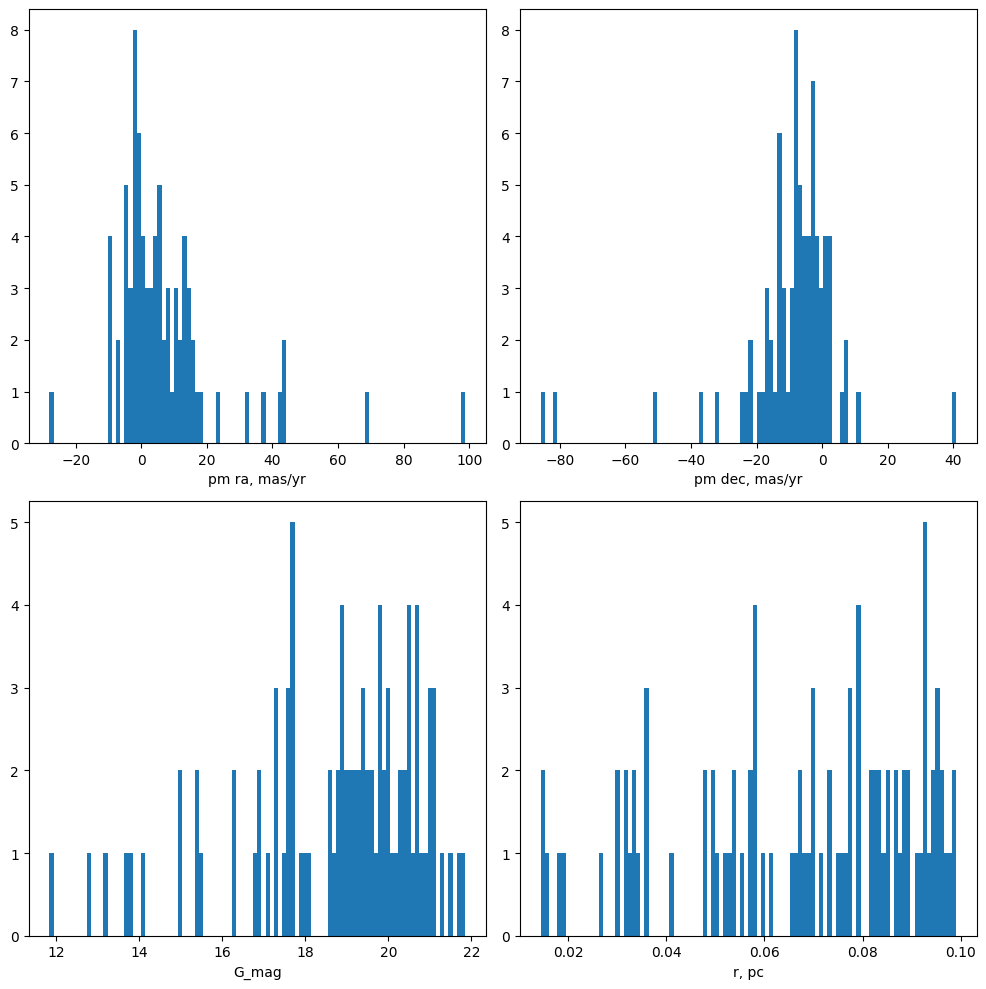

In [23]:
n_bins = 100
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=False, tight_layout=True)
axs[0][0].hist(Gaia_tab['pmRA'], bins=n_bins, label='pm ra')
axs[0][0].set_xlabel('pm ra, mas/yr')

axs[0][1].hist(Gaia_tab['pmDE'], bins=n_bins, label='pm dec')
axs[0][1].set_xlabel('pm dec, mas/yr')

axs[1][0].hist(Gaia_tab['Gmag'], bins=n_bins, label='G mag')
axs[1][0].set_xlabel('G_mag')

axs[1][1].hist(Gaia_tab['_r'], bins=n_bins, label='r')
axs[1][1].set_xlabel('r, pc')

plt.show()

In [28]:
from astroquery.skyview import SkyView
skyv = SkyView()
hduls = skyv.get_image_list(position="Sirius", radius=5*u.arcmin,
                            survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'])
print(hduls)

['https://skyview.gsfc.nasa.gov/tempspace/fits/skv1297402527853_1.fits', 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv1297402527853_2.fits', 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv1297402527853_3.fits', 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv1297402527853_4.fits']


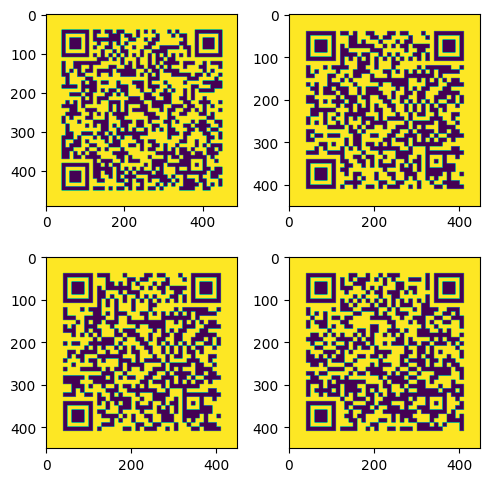

In [29]:
import qrcode
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

for i in range(len(hduls)):
    img = qrcode.make(hduls[i])
    img.save(f"W{i+1} code.png")
img = qrcode.make('https://www.youtube.com/watch?v=dQw4w9WgXcQ&pp=ygUXbmV2ZXIgZ29ubmEgZ2l2ZSB5b3UgdXA%3D')
img.save("W1 code.png")

img1 = mpimg.imread("W1 code.png")
img2 = mpimg.imread("W2 code.png")
img3 = mpimg.imread("W3 code.png")
img4 = mpimg.imread("W4 code.png")

fix, ax = plt.subplots(2, 2, figsize=(5, 5), sharey=False, tight_layout=True)
ax[0][0].imshow(img1)
ax[0][1].imshow(img2)
ax[1][0].imshow(img3)
ax[1][1].imshow(img4)

In [31]:
hduls = skyv.get_images(position="Vega", radius=3*u.arcmin,
                        survey=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22'])
for _ in range(len(hduls)):
    hduls[_].writeto(f"W{_+1} image.fits")

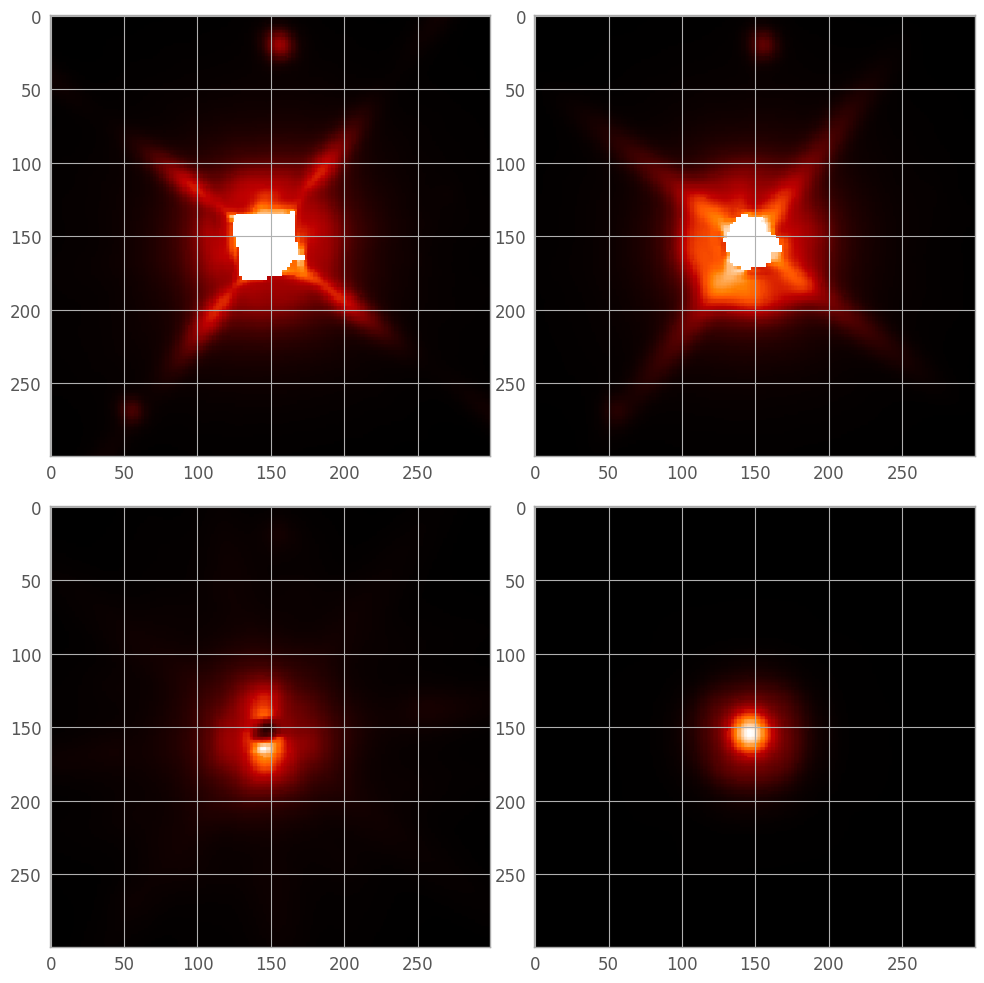

In [32]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import astropy_mpl_style

plt.style.use(astropy_mpl_style)
image_file = []
image_data = []
for i in range(4):
    image_file.append(get_pkg_data_filename(f'W{i+1} image.fits'))
    image_data.append(fits.getdata(image_file[i], ext=0))
fix, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=False, tight_layout=True)
ax[0][0].imshow(image_data[0])
ax[0][1].imshow(image_data[1])
ax[1][0].imshow(image_data[2])
ax[1][1].imshow(image_data[3])

In [2]:
from astropy_healpix import HEALPix
from scipy.interpolate import griddata

In [ ]:
def get_cat(RA, DEC, R):
    coord = SkyCoord(ra=RA * u.degree, dec=DEC * u.degree, frame='icrs')
    # set search cone   
    radius = Angle(R * u.deg)
    # set columns
    V = Vizier(columns=['RAJ2000', 'DEJ2000'])
    # set limit of rows, sort by distance default
    V.ROW_LIMIT = -1
    catalog = 'I/355/gaiadr3'
    # get data
    Gaia_tab = V.query_region(coord, radius=radius, catalog=catalog)
    return Gaia_tab


In [16]:
def do_some_pix(ra, dec, r, lvl, data):
    nside = 2**lvl
    hp = HEALPix(nside=nside, order='nested', frame='icrs')
    coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')
    search = hp.cone_search_skycoord(coord, radius=r * u.deg)
    id = data['HPId']
    indxs = np.isin(id, search)
    common = id[indxs]
    ext = data['A0'][indxs]
    # ext[np.isnan(ext)] = 0

    cd = hp.healpix_to_skycoord(common)
    _ra = np.unique(cd.ra.value)
    _dec = np.unique(cd.dec.value)
    X,Y = np.meshgrid(_ra, _dec)

    beta = griddata(np.transpose(np.array([cd.ra.value, cd.dec.value])), np.array(ext), (X,Y), method='nearest')   
    plt.pcolormesh(X, Y, beta, cmap=plt.cm.viridis, shading='auto')
    plt.ylabel('delta dec, deg')
    plt.xlabel('delta ra, deg')
    cbar = plt.colorbar()
    cbar.set_label('Av')
    plt.title(f'{ra} deg, {dec} deg, lvl = {lvl}')
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
data = np.load('I_355_tgextmap.npz')

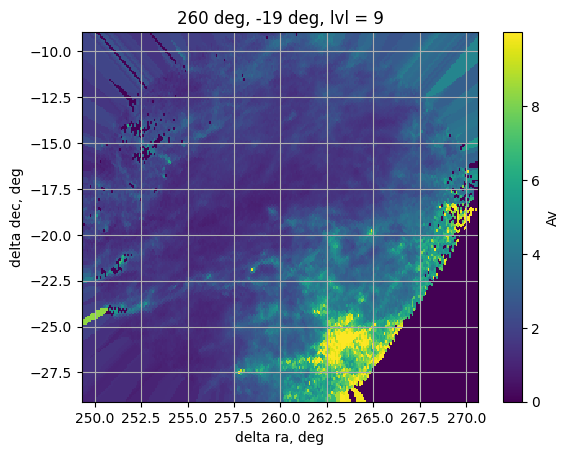

In [19]:
do_some_pix(ra=260, dec=-19, r=10, lvl=9, data=data)